In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"   #(xxxx is your specific GPU ID)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import math
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
print(torch.__version__)

1.10.1+cu102


In [5]:
# comparing to vit, here I changed kernel size, stride size and the size of fc1_1, due to the different outputsize of pre-train

In [6]:
###################### model 2 (keyword)###################### 

class keyword_net(nn.Module):
    def __init__(self):
        super(keyword_net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)            
        self.cvd = nn.Conv2d(in_channels=7, out_channels=3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)) 
        self.fc1_1 = nn.Linear(71910,128) 
        self.fc1_2 = nn.Linear(128,256) 
        self.keyword_output_1 = nn.Linear(256,11) 
        self.fc2_1 = nn.Linear(71910,512) # Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,name='fc2_1')
        self.fc2_2 = nn.Linear(512,512) # tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,name='fc2_2')
        self.getalphafromy2 = nn.Linear(512,512)
        self.fc2_3 = nn.Linear(1024,512)
        self.keyword_output_2 = nn.Linear(512,23) # tf.keras.layers.Dense(10, activation='softmax',name='command_output')


    def forward(self, x):
   
        # convert 512*7*7 to 512*49
#         print("before:" , x.shape)
        x =  x.reshape(x.size(0), x.size(1), x.size(2), -1)
#         print("after:" , x.shape)
        x = self.cvd(x)
        x = x.view(x.size(0), -1) 
        
        y1 = self.fc1_1(x)
        y1 = self.relu(y1)
        y1 = self.fc1_2(y1)
        y1 = self.sigmoid(y1) 
        y1 = self.keyword_output_1(y1)
        y1 = self.softmax(y1)
        
        y2 = self.fc2_1(x)
        y2 = self.relu(y2)
        y2 = self.fc2_2(y2)
        y2 = self.sigmoid(y2) 
        y2 = self.keyword_output_2(y2)
        y2 = self.softmax(y2)
        
        return y1,y2

In [7]:
class CombinedModel(nn.Module):
    def __init__(self, PRETRAIN_MODEL,keyword_net):
        super(CombinedModel, self).__init__()
        self.pretrain_model = PRETRAIN_MODEL
        self.keyword_net = keyword_net
        
    def forward(self, x):
#         print(x.shape)
#         print(x[:][0].shape)
        x1 = self.pretrain_model(x[:,0,:,:])
        x1 = torch.unsqueeze(x1, dim=1)
#         print(x1.shape)
        x2 = self.pretrain_model(x[:,1,:,:])
        x2 = torch.unsqueeze(x2, dim=1)
        x3 = self.pretrain_model(x[:,2,:,:])
        x3 = torch.unsqueeze(x3, dim=1)
        x4 = self.pretrain_model(x[:,3,:,:])
        x4 = torch.unsqueeze(x4, dim=1)        
        x5 = self.pretrain_model(x[:,4,:,:])
        x5 = torch.unsqueeze(x5, dim=1)        
        x6 = self.pretrain_model(x[:,5,:,:])
        x6 = torch.unsqueeze(x6, dim=1)        
        x7 = self.pretrain_model(x[:,6,:,:]) 
        x7 = torch.unsqueeze(x7, dim=1)      
                
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7), axis=1)
#         print(x.shape)
        y1,y2= self.keyword_net(x)
        return y1,y2
        

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_number = 11
train_image = 7 #10:20%, 20: 40%, 30:60%
val_image = 10
test_image = 10
# load_Data = ImageDataGenerator(preprocessing_function=preprocess_input)
load_Data = ImageDataGenerator(rescale=1./255)
Train_X = []
Train_Y_command = []
Train_Y_subject = []
Val_X = []
Val_Y_command = []
Val_Y_subject = []
Test_X = []
Test_Y_command = []
Test_Y_subject = []

for chan in range(1,8):
    chanl = str(chan)
    train_generator = load_Data.flow_from_directory("sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Train"%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = train_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    All_command_class = tf.keras.utils.to_categorical(train_generator.classes, num_classes=23)
    All_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    All_Inputs = [next(train_generator)[0][0] for _ in range(len(train_generator))]
    All_Inputs = np.array(All_Inputs)
    # count the training data number to select the training size
    count = []
    c = 0
    word = train_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and train_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = train_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)

    select_indexs_train = np.array(count) <= train_image
    train_participant_no =  participant_no[select_indexs_train]  
    Train_Inputs = All_Inputs[select_indexs_train]
    Train_command_class = All_command_class[select_indexs_train]
    Train_participant_class = All_participant_class[select_indexs_train]


    val_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Val'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                   shuffle=False)
    Val_command_class = tf.keras.utils.to_categorical( val_generator.classes, num_classes=23)
    image_names = val_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Val_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Val_Inputs = [next(val_generator)[0][0] for _ in range(len(val_generator))]
    Val_Inputs = np.array(Val_Inputs)
    count = []
    c = 0
    word = val_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and val_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = val_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_val = np.array(count) <= val_image
    val_participant_no =  participant_no[select_indexs_val]  
    Val_Inputs = Val_Inputs[select_indexs_val]
    Val_command_class = Val_command_class[select_indexs_val]
    Val_participant_class = Val_participant_class[select_indexs_val]

    test_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Test'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = test_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Test_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Test_command_class = tf.keras.utils.to_categorical(test_generator.classes, num_classes=23)
    Test_Inputs = [next(test_generator)[0][0] for _ in range(len(test_generator))]
    Test_Inputs = np.array(Test_Inputs)

    count = []
    c = 0
    word = test_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and test_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = test_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_test = np.array(count) <= test_image
    test_participant_no =  participant_no[select_indexs_test]  
    Test_Inputs = Test_Inputs[select_indexs_test]
    Test_command_class = Test_command_class[select_indexs_test]
    Test_participant_class = Test_participant_class[select_indexs_test]

    Train_X.append(Train_Inputs.transpose(0,3,1,2))
    Val_X.append(Val_Inputs.transpose(0,3,1,2))
    Test_X.append(Test_Inputs.transpose(0,3,1,2))
    
    
Train_Y_command = Train_command_class
Train_Y_subject = Train_participant_class
Val_Y_command = Val_command_class
Val_Y_subject = Val_participant_class
Test_Y_command = Test_command_class
Test_Y_subject = Test_participant_class

Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.


In [11]:
del val_generator,train_generator,test_generator

In [12]:
Train_X[0].shape,Val_X[0].shape,Test_X[0].shape

((1771, 3, 224, 224), (2530, 3, 224, 224), (2530, 3, 224, 224))

In [13]:
Train_Inputs = torch.from_numpy(np.array(Train_X))
Val_Inputs = torch.from_numpy(np.array(Val_X))
Test_Inputs = torch.from_numpy(np.array(Test_X))

In [14]:
Train_Inputs[0][0].shape

torch.Size([3, 224, 224])

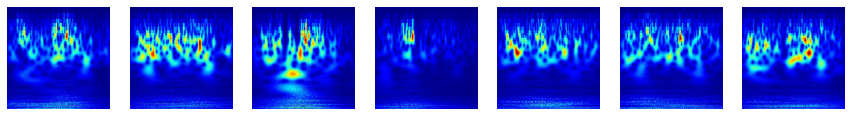

In [15]:
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(Train_Inputs[i][0].permute(1, 2, 0))
    plt.axis("off")
plt.show()
plt.close()

In [ ]:
y_test_sub = torch.from_numpy(Test_participant_class).to(device)
y_test_comd = torch.from_numpy(Test_command_class).to(device)

In [17]:
batch = 32
dataset = TensorDataset(Train_Inputs.permute(1,0,2,3,4), torch.from_numpy(Train_participant_class), torch.from_numpy(Train_command_class))
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

val_dataset = TensorDataset(Val_Inputs.permute(1,0,2,3,4), torch.from_numpy(Val_participant_class), torch.from_numpy(Val_command_class))
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

weight_a : 0.000000
1 run: 
-------------------------------
Epoch 1 :
loss: 3.126241683959961 , subject train accuracy: 0.0919744319149426 , command train accuracy: 0.06138392857142857 , val subject accuracy: 0.09090909090909091 , val command accuracy: 0.17707509881422925
Epoch 2 :
loss: 2.962724208831787 , subject train accuracy: 0.09420657477208547 , command train accuracy: 0.2208299514438425 , val subject accuracy: 0.091699604743083 , val command accuracy: 0.27233201581027666
Epoch 3 :
loss: 2.9076380729675293 , subject train accuracy: 0.10206980524318558 , command train accuracy: 0.3150872566870281 , val subject accuracy: 0.10158102766798419 , val command accuracy: 0.3339920948616601
Epoch 4 :
loss: 2.937809467315674 , subject train accuracy: 0.10805600668702807 , command train accuracy: 0.39103084430098534 , val subject accuracy: 0.108300395256917 , val command accuracy: 0.38814229249011856
Epoch 5 :
loss: 2.87260365486145 , subject train accuracy: 0.10146103905779975 , command tr

loss: 2.209419012069702 , subject train accuracy: 0.07756696428571429 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.07865612648221344 , val command accuracy: 0.8300395256916996
Epoch 41 :
loss: 2.209045886993408 , subject train accuracy: 0.07690746762922832 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.08023715415019762 , val command accuracy: 0.8316205533596838
Epoch 42 :
loss: 2.209059715270996 , subject train accuracy: 0.07310267857142858 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.07984189723320158 , val command accuracy: 0.8359683794466403
Epoch 43 :
loss: 2.209062099456787 , subject train accuracy: 0.07579139620065689 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.07786561264822134 , val command accuracy: 0.8347826086956521
Epoch 44 :
loss: 2.208814859390259 , subject train accuracy: 0.07421875 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.0782608695652174

loss: 2.210705518722534 , subject train accuracy: 0.10425121762922832 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.10395256916996047 , val command accuracy: 0.8241106719367589
Epoch 26 :
loss: 2.2098288536071777 , subject train accuracy: 0.09927962667175702 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.10553359683794467 , val command accuracy: 0.8241106719367589
Epoch 27 :
loss: 2.210573673248291 , subject train accuracy: 0.09709821428571429 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.10355731225296443 , val command accuracy: 0.8272727272727273
Epoch 28 :
loss: 2.2096126079559326 , subject train accuracy: 0.09760551952889987 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.1075098814229249 , val command accuracy: 0.8272727272727273
Epoch 29 :
loss: 2.209583282470703 , subject train accuracy: 0.09704748381461416 , command train accuracy: 1.0 , val subject accuracy: 0.10474308300395258 , v

loss: 2.2181668281555176 , subject train accuracy: 0.09090909095747131 , command train accuracy: 0.9553571428571429 , val subject accuracy: 0.09090909090909091 , val command accuracy: 0.7889328063241107
Epoch 22 :
loss: 2.248164415359497 , subject train accuracy: 0.08984375 , command train accuracy: 0.9598214285714286 , val subject accuracy: 0.09090909090909091 , val command accuracy: 0.775494071146245
Epoch 23 :
loss: 2.214080572128296 , subject train accuracy: 0.0941051138298852 , command train accuracy: 0.9949776785714286 , val subject accuracy: 0.09090909090909091 , val command accuracy: 0.7707509881422925
Epoch 24 :
loss: 2.211695909500122 , subject train accuracy: 0.08984375 , command train accuracy: 0.9977678571428571 , val subject accuracy: 0.09090909090909091 , val command accuracy: 0.7928853754940711
Epoch 25 :
loss: 2.2103683948516846 , subject train accuracy: 0.0919744319149426 , command train accuracy: 0.9977678571428571 , val subject accuracy: 0.09090909090909091 , val co

loss: 2.216249465942383 , subject train accuracy: 0.09136566572955676 , command train accuracy: 0.9977678571428571 , val subject accuracy: 0.08656126482213439 , val command accuracy: 0.8094861660079051
Epoch 19 :
loss: 2.2117369174957275 , subject train accuracy: 0.08482142857142858 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.09011857707509881 , val command accuracy: 0.8260869565217391
Epoch 20 :
loss: 2.2111072540283203 , subject train accuracy: 0.08426339285714286 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.0857707509881423 , val command accuracy: 0.8260869565217391
Epoch 21 :
loss: 2.210481882095337 , subject train accuracy: 0.08035714285714286 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.08616600790513834 , val command accuracy: 0.8264822134387352
Epoch 22 :
loss: 2.210279941558838 , subject train accuracy: 0.08203125 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.087351778656126

loss: 2.2196528911590576 , subject train accuracy: 0.07863230524318558 , command train accuracy: 0.9073660714285714 , val subject accuracy: 0.07984189723320158 , val command accuracy: 0.7304347826086957
Epoch 27 :
loss: 2.213676929473877 , subject train accuracy: 0.07310267857142858 , command train accuracy: 0.9107142857142857 , val subject accuracy: 0.08063241106719368 , val command accuracy: 0.7438735177865613
Epoch 28 :
loss: 2.300433874130249 , subject train accuracy: 0.07477678571428571 , command train accuracy: 0.9096489452889988 , val subject accuracy: 0.07865612648221344 , val command accuracy: 0.7430830039525692
Epoch 29 :
loss: 2.3008084297180176 , subject train accuracy: 0.07584212667175702 , command train accuracy: 0.9113230524318559 , val subject accuracy: 0.08023715415019762 , val command accuracy: 0.7407114624505929
Epoch 30 :
loss: 2.298804521560669 , subject train accuracy: 0.07645089285714286 , command train accuracy: 0.9129971595747131 , val subject accuracy: 0.08300

loss: 2.2079670429229736 , subject train accuracy: 0.08081371762922832 , command train accuracy: 1.0 , val subject accuracy: 0.0782608695652174 , val command accuracy: 0.8043478260869565
Epoch 66 :
loss: 2.2079811096191406 , subject train accuracy: 0.07254464285714286 , command train accuracy: 1.0 , val subject accuracy: 0.07707509881422925 , val command accuracy: 0.8071146245059289
Epoch 67 :
loss: 2.208087205886841 , subject train accuracy: 0.07310267857142858 , command train accuracy: 1.0 , val subject accuracy: 0.07628458498023716 , val command accuracy: 0.8071146245059289
Epoch 68 :
loss: 2.210888624191284 , subject train accuracy: 0.07198660714285714 , command train accuracy: 1.0 , val subject accuracy: 0.07707509881422925 , val command accuracy: 0.8067193675889328
Epoch 69 :
loss: 2.2081055641174316 , subject train accuracy: 0.07695819810032845 , command train accuracy: 1.0 , val subject accuracy: 0.07707509881422925 , val command accuracy: 0.8098814229249012
Epoch 70 :
loss: 2.

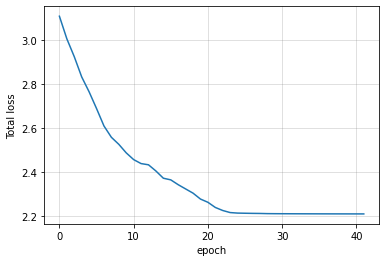

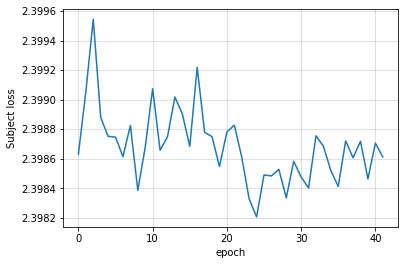

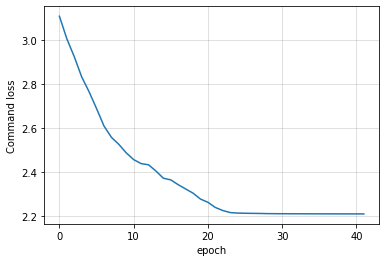

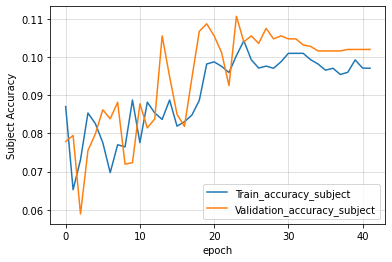

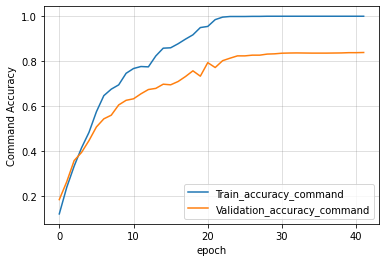

weight_a : 0.250000
1 run: 
-------------------------------
Epoch 1 :
loss: 3.672203540802002 , subject train accuracy: 0.5057832790272576 , command train accuracy: 0.06356534095747131 , val subject accuracy: 0.7822134387351779 , val command accuracy: 0.10553359683794467
Epoch 2 :
loss: 3.504910945892334 , subject train accuracy: 0.8695211048637118 , command train accuracy: 0.1539163962006569 , val subject accuracy: 0.8932806324110671 , val command accuracy: 0.1624505928853755
Epoch 3 :
loss: 3.410452365875244 , subject train accuracy: 0.8997057633740562 , command train accuracy: 0.24031047097274236 , val subject accuracy: 0.9043478260869565 , val command accuracy: 0.28774703557312253
Epoch 4 :
loss: 3.4294588565826416 , subject train accuracy: 0.9341517857142857 , command train accuracy: 0.34806209430098534 , val subject accuracy: 0.9592885375494071 , val command accuracy: 0.3652173913043478
Epoch 5 :
loss: 3.3139877319335938 , subject train accuracy: 0.9916294642857143 , command trai

loss: 2.5946147441864014 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8794466403162056
Epoch 45 :
loss: 2.5946431159973145 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8790513833992095
Epoch 46 :
loss: 2.594573497772217 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8794466403162056
Epoch 47 :
loss: 2.594496726989746 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8790513833992095
Epoch 48 :
loss: 2.594534158706665 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8798418972332016
Epoch 49 :
loss: 2.594391345977783 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject 


Run  1 Subject Accuracy 0.9992094861660079 command Accuracy is : 0.8786561264822135 Sub_1: 0.9 Sub_2: 0.8869565217391304 Sub_3: 0.8782608695652174 Sub_4: 0.8869565217391304 Sub_5: 0.9 Sub_6: 0.9217391304347826 Sub_7: 0.9434782608695652 Sub_8: 0.9217391304347826 Sub_9: 0.9 Sub_10: 0.8 Sub_11: 0.7260869565217392
2 run: 
-------------------------------
Epoch 1 :
loss: 3.6875100135803223 , subject train accuracy: 0.3446124190730708 , command train accuracy: 0.05346996762922832 , val subject accuracy: 0.7304347826086957 , val command accuracy: 0.10316205533596838
Epoch 2 :
loss: 3.5458950996398926 , subject train accuracy: 0.7858157477208546 , command train accuracy: 0.1193181819149426 , val subject accuracy: 0.7932806324110672 , val command accuracy: 0.15454545454545454
Epoch 3 :
loss: 3.386174201965332 , subject train accuracy: 0.8098112834351403 , command train accuracy: 0.20571225668702806 , val subject accuracy: 0.8118577075098814 , val command accuracy: 0.258102766798419
Epoch 4 :
lo

loss: 2.5950636863708496 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.867193675889328
Epoch 42 :
loss: 2.595590353012085 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.866403162055336
Epoch 43 :
loss: 2.5950684547424316 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8648221343873518
Epoch 44 :
loss: 2.5948073863983154 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8652173913043478
Epoch 45 :
loss: 2.5948469638824463 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8656126482213439
Epoch 46 :
loss: 2.594848871231079 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val sub

loss: 2.5952751636505127 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8569169960474309
Epoch 34 :
loss: 2.5954813957214355 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8573122529644269
Epoch 35 :
loss: 2.59517765045166 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8569169960474309
Epoch 36 :
loss: 2.5951998233795166 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.858102766798419
Epoch 37 :
loss: 2.5948235988616943 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.858102766798419
Epoch 38 :
loss: 2.59509825706

loss: 2.602168321609497 , subject train accuracy: 1.0 , command train accuracy: 0.9983258928571429 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.8292490118577075
Epoch 22 :
loss: 2.6000232696533203 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8727272727272727
Epoch 23 :
loss: 2.599339485168457 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8715415019762845
Epoch 24 :
loss: 2.5971176624298096 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8766798418972332
Epoch 25 :
loss: 2.597271203994751 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8762845849802372
Epoch 26 :
loss: 2.5969324111938477 , subjec

loss: 3.2406165599823 , subject train accuracy: 1.0 , command train accuracy: 0.6298193995441709 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.5778656126482213
Epoch 9 :
loss: 2.9394941329956055 , subject train accuracy: 1.0 , command train accuracy: 0.6836952120065689 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.591304347826087
Epoch 10 :
loss: 2.9795830249786377 , subject train accuracy: 1.0 , command train accuracy: 0.7010957790272576 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.6387351778656126
Epoch 11 :
loss: 2.8138723373413086 , subject train accuracy: 1.0 , command train accuracy: 0.7618202120065689 , val subject accuracy: 0.9952569169960475 , val command accuracy: 0.6632411067193675
Epoch 12 :
loss: 2.827740430831909 , subject train accuracy: 1.0 , command train accuracy: 0.8120434262922832 , val subject accuracy: 0.9964426877470356 , val command accuracy: 0.7039525691699605
Epoch 13 :
loss: 2.6279275417327

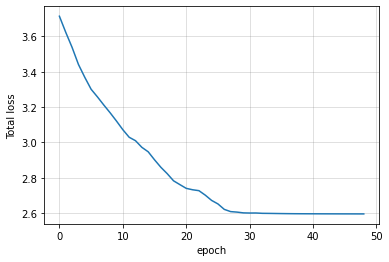

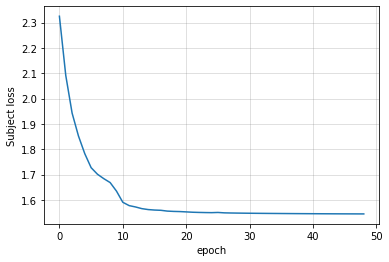

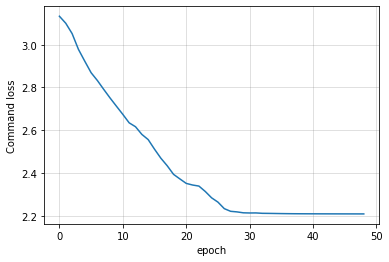

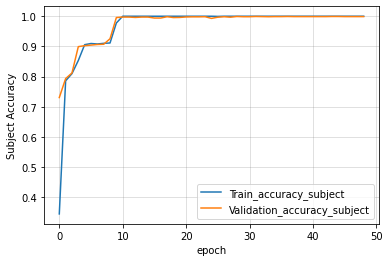

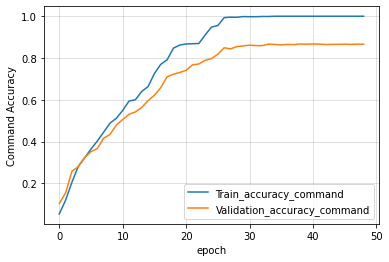

weight_a : 0.500000
1 run: 
-------------------------------
Epoch 1 :
loss: 4.158243179321289 , subject train accuracy: 0.5826400167175702 , command train accuracy: 0.045200892857142856 , val subject accuracy: 0.8494071146245059 , val command accuracy: 0.08339920948616601
Epoch 2 :
loss: 3.9929308891296387 , subject train accuracy: 0.8911830357142857 , command train accuracy: 0.09090909095747131 , val subject accuracy: 0.8988142292490119 , val command accuracy: 0.11699604743083004
Epoch 3 :
loss: 3.9127871990203857 , subject train accuracy: 0.9085328738604274 , command train accuracy: 0.14052353905779974 , val subject accuracy: 0.9102766798418972 , val command accuracy: 0.1774703557312253
Epoch 4 :
loss: 3.9754395484924316 , subject train accuracy: 0.9693080357142857 , command train accuracy: 0.24208603905779974 , val subject accuracy: 0.9920948616600791 , val command accuracy: 0.24980237154150198
Epoch 5 :
loss: 3.6461148262023926 , subject train accuracy: 0.9972098214285714 , command

loss: 2.9811501502990723 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8766798418972332
Epoch 43 :
loss: 2.981048583984375 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8790513833992095
Epoch 44 :
loss: 2.9811770915985107 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8786561264822135
Epoch 45 :
loss: 2.98081111907959 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8786561264822135
Epoch 46 :
loss: 2.980924367904663 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8762845849802372
Epoch 47 :
loss: 2.98084378242

loss: 2.9975838661193848 , subject train accuracy: 1.0 , command train accuracy: 0.9341517857142857 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7976284584980237
Epoch 22 :
loss: 3.0783092975616455 , subject train accuracy: 1.0 , command train accuracy: 0.9531757310032845 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8260869565217391
Epoch 23 :
loss: 2.987652540206909 , subject train accuracy: 1.0 , command train accuracy: 0.9520089285714286 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8027667984189724
Epoch 24 :
loss: 2.9865732192993164 , subject train accuracy: 1.0 , command train accuracy: 0.95703125 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.841106719367589
Epoch 25 :
loss: 3.026078939437866 , subject train accuracy: 1.0 , command train accuracy: 0.9893973214285714 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8154150197628458
Epoch 26 :
loss: 2.997648239135742 , 

loss: 2.9798054695129395 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.892094861660079
Epoch 66 :
loss: 2.979874610900879 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.892094861660079
Epoch 67 :
loss: 2.9797961711883545 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.892094861660079
Epoch 68 :
loss: 2.9798130989074707 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.892490118577075
Epoch 69 :
loss: 2.9796996116638184 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.892094861660079
Epoch 70 :
loss: 2.979867458343506 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

loss: 3.0814552307128906 , subject train accuracy: 1.0 , command train accuracy: 0.8633319810032845 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7367588932806324
Epoch 19 :
loss: 3.006273031234741 , subject train accuracy: 1.0 , command train accuracy: 0.8900669642857143 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.741501976284585
Epoch 20 :
loss: 3.0106725692749023 , subject train accuracy: 1.0 , command train accuracy: 0.9224330357142857 , val subject accuracy: 0.9964426877470356 , val command accuracy: 0.7857707509881423
Epoch 21 :
loss: 3.083711624145508 , subject train accuracy: 1.0 , command train accuracy: 0.9481534095747131 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8051383399209486
Epoch 22 :
loss: 2.995875358581543 , subject train accuracy: 1.0 , command train accuracy: 0.9564732142857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8399209486166008
Epoch 23 :
loss: 3.03048133850

loss: 3.0016534328460693 , subject train accuracy: 1.0 , command train accuracy: 0.8638392857142857 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.7426877470355732
Epoch 17 :
loss: 3.0209484100341797 , subject train accuracy: 1.0 , command train accuracy: 0.9285714285714286 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7913043478260869
Epoch 18 :
loss: 3.0061426162719727 , subject train accuracy: 1.0 , command train accuracy: 0.9481026785714286 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.7841897233201581
Epoch 19 :
loss: 2.989635944366455 , subject train accuracy: 1.0 , command train accuracy: 0.9559151785714286 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8288537549407115
Epoch 20 :
loss: 3.0330495834350586 , subject train accuracy: 1.0 , command train accuracy: 0.9810267857142857 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.83399209486166
Epoch 21 :
loss: 2.9876017570

loss: 3.2793216705322266 , subject train accuracy: 1.0 , command train accuracy: 0.7702414776597705 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.7019762845849803
Epoch 11 :
loss: 3.345066547393799 , subject train accuracy: 1.0 , command train accuracy: 0.8059557633740562 , val subject accuracy: 0.9964426877470356 , val command accuracy: 0.7209486166007905
Epoch 12 :
loss: 3.1000401973724365 , subject train accuracy: 1.0 , command train accuracy: 0.8583096595747131 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.741106719367589
Epoch 13 :
loss: 3.2617266178131104 , subject train accuracy: 1.0 , command train accuracy: 0.8639914776597705 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.7486166007905138
Epoch 14 :
loss: 3.083635091781616 , subject train accuracy: 1.0 , command train accuracy: 0.8683543024318559 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.7731225296442688
Epoch 15 :
loss: 3.0685963630

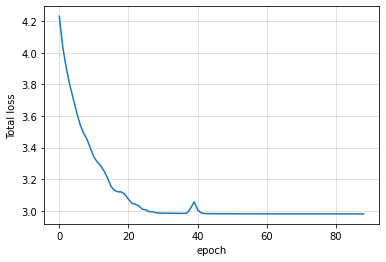

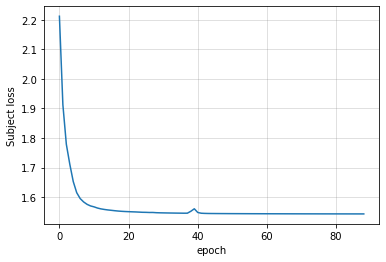

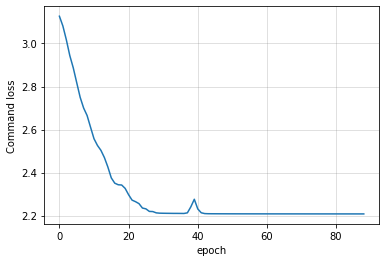

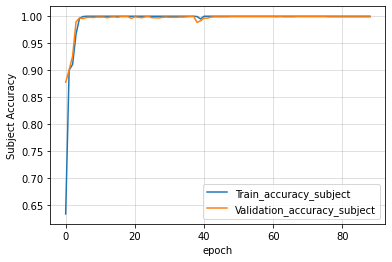

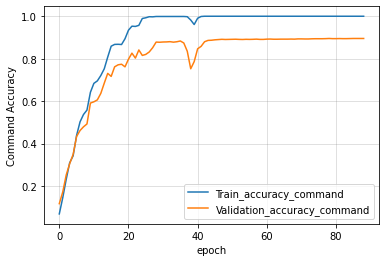

weight_a : 0.750000
1 run: 
-------------------------------
Epoch 1 :
loss: 4.512842178344727 , subject train accuracy: 0.6027800334351403 , command train accuracy: 0.09364853905779975 , val subject accuracy: 0.8367588932806325 , val command accuracy: 0.14624505928853754
Epoch 2 :
loss: 4.23468017578125 , subject train accuracy: 0.9515016238604274 , command train accuracy: 0.20403814954417093 , val subject accuracy: 0.983794466403162 , val command accuracy: 0.2316205533596838
Epoch 3 :
loss: 4.347363471984863 , subject train accuracy: 0.9972098214285714 , command train accuracy: 0.2872869319149426 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.2992094861660079
Epoch 4 :
loss: 4.234165191650391 , subject train accuracy: 1.0 , command train accuracy: 0.3581067371581282 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.35296442687747037
Epoch 5 :
loss: 3.8757987022399902 , subject train accuracy: 1.0 , command train accuracy: 0.44718952902725767 , 

loss: 3.366968870162964 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8632411067193676
Epoch 45 :
loss: 3.3669185638427734 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8632411067193676
Epoch 46 :
loss: 3.3668084144592285 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8632411067193676
Epoch 47 :
loss: 3.3666274547576904 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8632411067193676
Epoch 48 :
loss: 3.3665952682495117 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8632411067193676
Epoch 49 :
loss: 3.366619110107422 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

loss: 3.3682973384857178 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8798418972332016
Epoch 37 :
loss: 3.368067979812622 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8802371541501977
Epoch 38 :
loss: 3.3678932189941406 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8794466403162056
Epoch 39 :
loss: 3.36773419380188 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8806324110671937
Epoch 40 :
loss: 3.3672640323638916 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8814229249011858
Epoch 41 :
loss: 3.3678622245788574 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject

loss: 3.6369454860687256 , subject train accuracy: 1.0 , command train accuracy: 0.9064021919454847 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.758893280632411
Epoch 22 :
loss: 3.3929319381713867 , subject train accuracy: 1.0 , command train accuracy: 0.9553571428571429 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.8102766798418972
Epoch 23 :
loss: 3.379840612411499 , subject train accuracy: 1.0 , command train accuracy: 0.9938616071428571 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8260869565217391
Epoch 24 :
loss: 3.374648094177246 , subject train accuracy: 1.0 , command train accuracy: 0.9977678571428571 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8604743083003953
Epoch 25 :
loss: 3.373706579208374 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8731225296442687
Epoch 26 :
loss: 3.37346792221

loss: 3.450474977493286 , subject train accuracy: 1.0 , command train accuracy: 0.9402901785714286 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.7952569169960474
Epoch 16 :
loss: 3.3864545822143555 , subject train accuracy: 1.0 , command train accuracy: 0.9542410714285714 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8102766798418972
Epoch 17 :
loss: 3.3761987686157227 , subject train accuracy: 1.0 , command train accuracy: 0.9553571428571429 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.824901185770751
Epoch 18 :
loss: 3.4671010971069336 , subject train accuracy: 1.0 , command train accuracy: 0.9548498381461415 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8351778656126482
Epoch 19 :
loss: 3.464949607849121 , subject train accuracy: 1.0 , command train accuracy: 0.9548498381461415 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8355731225296442
Epoch 20 :
loss: 3.3770847320

loss: 3.562180280685425 , subject train accuracy: 1.0 , command train accuracy: 0.8968648548637118 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.7470355731225297
Epoch 18 :
loss: 3.4677734375 , subject train accuracy: 1.0 , command train accuracy: 0.9129971595747131 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.799209486166008
Epoch 19 :
loss: 3.487485885620117 , subject train accuracy: 1.0 , command train accuracy: 0.9431310881461415 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8003952569169961
Epoch 20 :
loss: 3.408139944076538 , subject train accuracy: 1.0 , command train accuracy: 0.9525669642857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7849802371541502
Epoch 21 :
loss: 3.3798530101776123 , subject train accuracy: 1.0 , command train accuracy: 0.9520089285714286 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8150197628458498
Epoch 22 :
loss: 3.373131275177002 ,

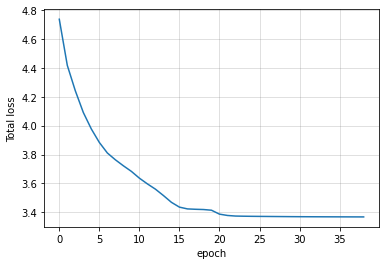

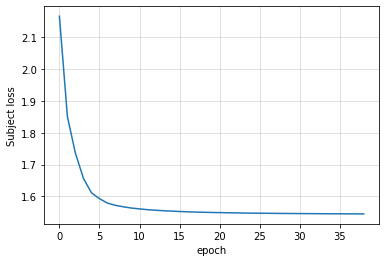

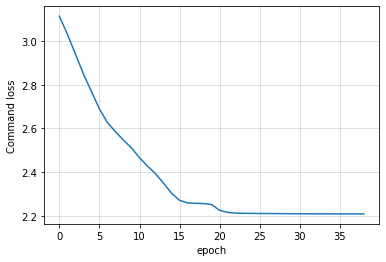

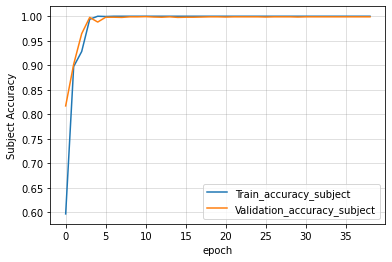

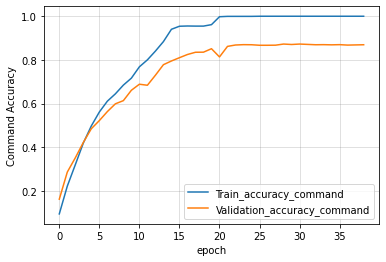

weight_a : 1.000000
1 run: 
-------------------------------
Epoch 1 :
loss: 5.052898406982422 , subject train accuracy: 0.5882203738604274 , command train accuracy: 0.06630478905779975 , val subject accuracy: 0.8355731225296442 , val command accuracy: 0.11185770750988143
Epoch 2 :
loss: 4.979155540466309 , subject train accuracy: 0.9431310881461415 , command train accuracy: 0.15178571428571427 , val subject accuracy: 0.9814229249011858 , val command accuracy: 0.191699604743083
Epoch 3 :
loss: 4.7145185470581055 , subject train accuracy: 0.9972098214285714 , command train accuracy: 0.2610085228724139 , val subject accuracy: 0.9964426877470356 , val command accuracy: 0.2984189723320158
Epoch 4 :
loss: 4.4931488037109375 , subject train accuracy: 0.9988839285714286 , command train accuracy: 0.3474533281155995 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.35296442687747037
Epoch 5 :
loss: 4.521761894226074 , subject train accuracy: 1.0 , command train accuracy: 0.415

loss: 3.7536377906799316 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8774703557312253
Epoch 43 :
loss: 3.753350257873535 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8770750988142293
Epoch 44 :
loss: 3.7533626556396484 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8766798418972332
Epoch 45 :
loss: 3.7530813217163086 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8770750988142293
Epoch 46 :
loss: 3.7530460357666016 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.8774703557312253
Epoch 47 :
loss: 3.75300121

loss: 3.7566370964050293 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8849802371541502
Epoch 33 :
loss: 3.7557992935180664 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8841897233201581
Epoch 34 :
loss: 3.755152702331543 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8818181818181818
Epoch 35 :
loss: 3.75512957572937 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8845849802371542
Epoch 36 :
loss: 3.755467176437378 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8857707509881423
Epoch 37 :
loss: 3.7546205520629883 , subject train accuracy: 1.0 , command

loss: 3.764739990234375 , subject train accuracy: 1.0 , command train accuracy: 0.99609375 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8185770750988143
Epoch 28 :
loss: 3.7605175971984863 , subject train accuracy: 1.0 , command train accuracy: 0.99609375 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8122529644268774
Epoch 29 :
loss: 3.7588610649108887 , subject train accuracy: 1.0 , command train accuracy: 0.9949776785714286 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8098814229249012
Epoch 30 :
loss: 3.7590396404266357 , subject train accuracy: 1.0 , command train accuracy: 0.9949776785714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8391304347826087
Epoch 31 :
loss: 3.839458465576172 , subject train accuracy: 1.0 , command train accuracy: 0.9972605524318559 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.866403162055336
Epoch 32 :
loss: 3.756253480911255 , subject 

loss: 3.8598690032958984 , subject train accuracy: 1.0 , command train accuracy: 0.8242694810032845 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7292490118577075
Epoch 15 :
loss: 3.8549797534942627 , subject train accuracy: 1.0 , command train accuracy: 0.8259435881461415 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.733201581027668
Epoch 16 :
loss: 4.165024757385254 , subject train accuracy: 1.0 , command train accuracy: 0.8411627433129719 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7596837944664032
Epoch 17 :
loss: 3.863618850708008 , subject train accuracy: 1.0 , command train accuracy: 0.9090909095747131 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.7786561264822134
Epoch 18 :
loss: 3.9498932361602783 , subject train accuracy: 1.0 , command train accuracy: 0.9091416405779975 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.7470355731225297
Epoch 19 :
loss: 3.9419703483

loss: 3.8965229988098145 , subject train accuracy: 1.0 , command train accuracy: 0.6897828738604274 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.607905138339921
Epoch 11 :
loss: 4.045971870422363 , subject train accuracy: 1.0 , command train accuracy: 0.6937905848026276 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.632806324110672
Epoch 12 :
loss: 4.2258710861206055 , subject train accuracy: 1.0 , command train accuracy: 0.7402090100305421 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.6608695652173913
Epoch 13 :
loss: 3.996305227279663 , subject train accuracy: 1.0 , command train accuracy: 0.8003246762922832 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.6948616600790514
Epoch 14 :
loss: 4.042110443115234 , subject train accuracy: 1.0 , command train accuracy: 0.8204646919454847 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7158102766798419
Epoch 15 :
loss: 3.8700826168060

loss: 3.752333641052246 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8743083003952569
Epoch 54 :
loss: 3.752286434173584 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8739130434782608
Epoch 55 :
loss: 3.752345085144043 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8743083003952569
Run:  5 , and its best  1.8743083003952568

Run  5 Subject Accuracy 0.9992094861660079 command Accuracy is : 0.8778656126482214 Sub_1: 0.8956521739130435 Sub_2: 0.8652173913043478 Sub_3: 0.908695652173913 Sub_4: 0.9130434782608695 Sub_5: 0.8695652173913043 Sub_6: 0.9217391304347826 Sub_7: 0.9434782608695652 Sub_8: 0.8869565217391304 Sub_9: 0.8826086956521739 Sub_10: 0.8173913043478261 Sub_11: 0.7521739130434782


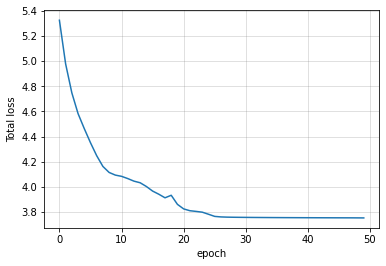

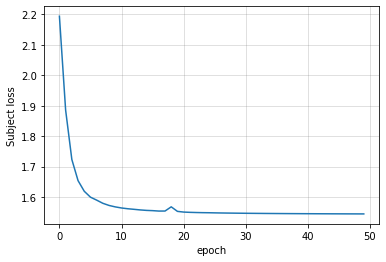

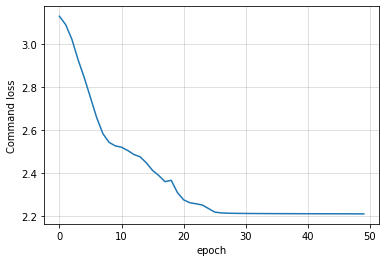

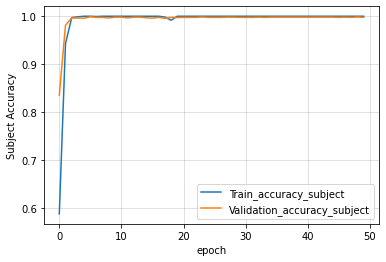

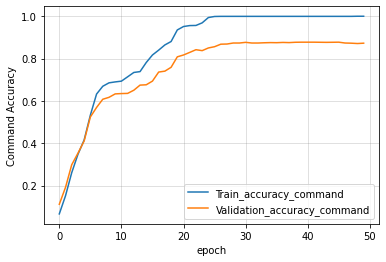

weight_a : 1.250000
1 run: 
-------------------------------
Epoch 1 :
loss: 5.704098224639893 , subject train accuracy: 0.6362621762922832 , command train accuracy: 0.08477069810032845 , val subject accuracy: 0.8636363636363636 , val command accuracy: 0.14031620553359683
Epoch 2 :
loss: 5.371077537536621 , subject train accuracy: 0.8935166405779975 , command train accuracy: 0.15827922097274236 , val subject accuracy: 0.9027667984189723 , val command accuracy: 0.18735177865612648
Epoch 3 :
loss: 5.283205032348633 , subject train accuracy: 0.9064021919454847 , command train accuracy: 0.21408279240131378 , val subject accuracy: 0.9031620553359684 , val command accuracy: 0.2316205533596838
Epoch 4 :
loss: 5.089815139770508 , subject train accuracy: 0.9363839285714286 , command train accuracy: 0.2990056819149426 , val subject accuracy: 0.9798418972332016 , val command accuracy: 0.3007905138339921
Epoch 5 :
loss: 4.7681884765625 , subject train accuracy: 0.9972098214285714 , command train ac

loss: 4.139578342437744 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8822134387351779
Epoch 44 :
loss: 4.139830589294434 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8818181818181818
Epoch 45 :
loss: 4.139497756958008 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8814229249011858
Run:  1 , and its best  1.8857707509881423

Run  1 Subject Accuracy 0.9988142292490119 command Accuracy is : 0.8806324110671937 Sub_1: 0.8739130434782608 Sub_2: 0.8956521739130435 Sub_3: 0.8782608695652174 Sub_4: 0.9260869565217391 Sub_5: 0.908695652173913 Sub_6: 0.9043478260869565 Sub_7: 0.9173913043478261 Sub_8: 0.9173913043478261 Sub_9: 0.8956521739130435 Sub_10: 0.8130434782608695 Sub_11: 0.7565217391304347
2 run: 
-------------------------------
Epoch 1 :
los

loss: 4.141899108886719 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.866403162055336
Epoch 39 :
loss: 4.140873432159424 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8683794466403162
Epoch 40 :
loss: 4.14056921005249 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.866403162055336
Epoch 41 :
loss: 4.140291213989258 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8683794466403162
Epoch 42 :
loss: 4.14041805267334 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8691699604743083
Epoch 43 :
loss: 4.1401166915893555 , subject train accuracy: 1.0 , command train accuracy: 1.0 , va

loss: 4.359142303466797 , subject train accuracy: 1.0 , command train accuracy: 0.693181819149426 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.6118577075098814
Epoch 12 :
loss: 4.690644264221191 , subject train accuracy: 1.0 , command train accuracy: 0.6911525976444993 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.6260869565217392
Epoch 13 :
loss: 4.502518653869629 , subject train accuracy: 1.0 , command train accuracy: 0.6977475647415433 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.6458498023715415
Epoch 14 :
loss: 4.590536594390869 , subject train accuracy: 1.0 , command train accuracy: 0.7680600647415433 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.6770750988142292
Epoch 15 :
loss: 4.703547477722168 , subject train accuracy: 1.0 , command train accuracy: 0.8234070619302136 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7229249011857708
Epoch 16 :
loss: 4.2636184692382

loss: 5.027800559997559 , subject train accuracy: 0.9988839285714286 , command train accuracy: 0.31574675334351404 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.31225296442687744
Epoch 6 :
loss: 4.679269313812256 , subject train accuracy: 1.0 , command train accuracy: 0.37687702902725767 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.38537549407114624
Epoch 7 :
loss: 4.687499523162842 , subject train accuracy: 1.0 , command train accuracy: 0.4360795457448278 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.40474308300395256
Epoch 8 :
loss: 4.644781589508057 , subject train accuracy: 1.0 , command train accuracy: 0.4801643671733992 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.4474308300395257
Epoch 9 :
loss: 4.5731611251831055 , subject train accuracy: 1.0 , command train accuracy: 0.5359172075986862 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.49486166007905136
Epoch 10 :
lo

loss: 4.139676570892334 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8865612648221344
Epoch 48 :
loss: 4.139853477478027 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8861660079051383
Epoch 49 :
loss: 4.139278888702393 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8869565217391304
Epoch 50 :
loss: 4.139199256896973 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8865612648221344
Epoch 51 :
loss: 4.138882637023926 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8865612648221344
Epoch 52 :
loss: 4.138888359069824 ,

loss: 4.145530700683594 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8525691699604743
Epoch 29 :
loss: 4.145768165588379 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8774703557312253
Epoch 30 :
loss: 4.143929481506348 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8814229249011858
Epoch 31 :
loss: 4.143582344055176 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8814229249011858
Epoch 32 :
loss: 4.142936706542969 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8818181818181818
Epoch 33 :
loss: 4.142393112182

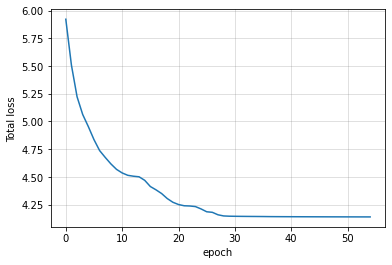

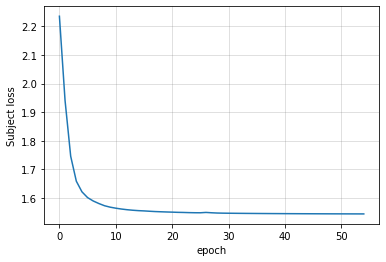

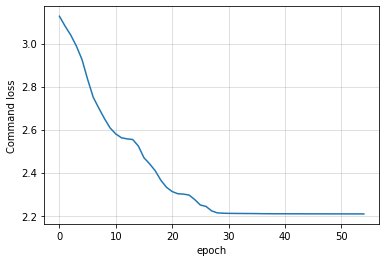

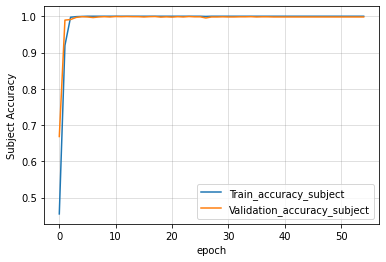

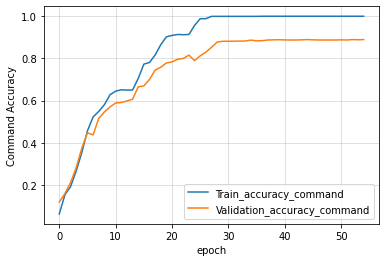

weight_a : 1.500000
1 run: 
-------------------------------
Epoch 1 :
loss: 6.018667221069336 , subject train accuracy: 0.7393973214285714 , command train accuracy: 0.07751623381461416 , val subject accuracy: 0.8802371541501977 , val command accuracy: 0.14861660079051384
Epoch 2 :
loss: 5.665678977966309 , subject train accuracy: 0.9386160714285714 , command train accuracy: 0.18633319810032845 , val subject accuracy: 0.9754940711462451 , val command accuracy: 0.18735177865612648
Epoch 3 :
loss: 5.476995468139648 , subject train accuracy: 0.9910714285714286 , command train accuracy: 0.2542106333587851 , val subject accuracy: 0.9885375494071146 , val command accuracy: 0.2948616600790514
Epoch 4 :
loss: 5.361392974853516 , subject train accuracy: 0.9994419642857143 , command train accuracy: 0.3318283281155995 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.32964426877470354
Epoch 5 :
loss: 5.147716522216797 , subject train accuracy: 1.0 , command train accuracy: 0.398

loss: 4.525728225708008 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.883399209486166
Epoch 44 :
loss: 4.525636196136475 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8841897233201581
Epoch 45 :
loss: 4.525356292724609 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8837944664031621
Epoch 46 :
loss: 4.524988174438477 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8837944664031621
Epoch 47 :
loss: 4.524839878082275 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8837944664031621
Epoch 48 :
loss: 4.5246934890747

loss: 4.625490188598633 , subject train accuracy: 1.0 , command train accuracy: 0.9526176952889988 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.783399209486166
Epoch 30 :
loss: 4.537591457366943 , subject train accuracy: 1.0 , command train accuracy: 0.9575892857142857 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8122529644268774
Epoch 31 :
loss: 4.59153413772583 , subject train accuracy: 1.0 , command train accuracy: 0.9949776785714286 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.7913043478260869
Epoch 32 :
loss: 4.557024955749512 , subject train accuracy: 1.0 , command train accuracy: 0.99609375 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7948616600790513
Epoch 33 :
loss: 4.531336307525635 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8312252964426877
Epoch 34 :
loss: 4.529978275299072 , subj

Epoch 1 :
loss: 6.15838623046875 , subject train accuracy: 0.595525569149426 , command train accuracy: 0.06975446428571429 , val subject accuracy: 0.8122529644268774 , val command accuracy: 0.12213438735177866
Epoch 2 :
loss: 5.811943531036377 , subject train accuracy: 0.8689123381461415 , command train accuracy: 0.1651278409574713 , val subject accuracy: 0.9027667984189723 , val command accuracy: 0.20553359683794467
Epoch 3 :
loss: 5.666687965393066 , subject train accuracy: 0.9280641238604274 , command train accuracy: 0.23817978905779974 , val subject accuracy: 0.9561264822134388 , val command accuracy: 0.2592885375494071
Epoch 4 :
loss: 5.4901275634765625 , subject train accuracy: 0.9838169642857143 , command train accuracy: 0.3028612014438425 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.30355731225296445
Epoch 5 :
loss: 5.169626235961914 , subject train accuracy: 0.9983258928571429 , command train accuracy: 0.3819500814591135 , val subject accuracy: 0.999209

loss: 4.525363445281982 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8782608695652174
Epoch 46 :
loss: 4.525383949279785 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8782608695652174
Run:  3 , and its best  1.8786561264822135

Run  3 Subject Accuracy 0.9988142292490119 command Accuracy is : 0.8865612648221344 Sub_1: 0.9043478260869565 Sub_2: 0.8956521739130435 Sub_3: 0.8782608695652174 Sub_4: 0.908695652173913 Sub_5: 0.8913043478260869 Sub_6: 0.9217391304347826 Sub_7: 0.9434782608695652 Sub_8: 0.9347826086956522 Sub_9: 0.8695652173913043 Sub_10: 0.8173913043478261 Sub_11: 0.7869565217391304
4 run: 
-------------------------------
Epoch 1 :
loss: 6.194838523864746 , subject train accuracy: 0.5815746762922832 , command train accuracy: 0.060217126671757014 , val subject accuracy: 0.8055335968379447 , val command accuracy: 0

loss: 4.526768684387207 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.891699604743083
Epoch 41 :
loss: 4.526103973388672 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892094861660079
Epoch 42 :
loss: 4.526169300079346 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892490118577075
Epoch 43 :
loss: 4.526201248168945 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892094861660079
Epoch 44 :
loss: 4.525959014892578 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.892490118577075
Epoch 45 :
loss: 4.5257158279418945 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accura

loss: 4.530497074127197 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8841897233201581
Epoch 30 :
loss: 4.529107093811035 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8826086956521739
Epoch 31 :
loss: 4.529481887817383 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8845849802371542
Epoch 32 :
loss: 4.528481483459473 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8837944664031621
Epoch 33 :
loss: 4.528987407684326 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8837944664031621
Epoch 34 :
loss: 4.528896331787109 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subje

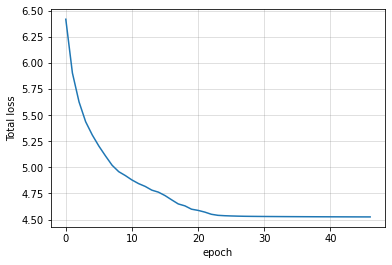

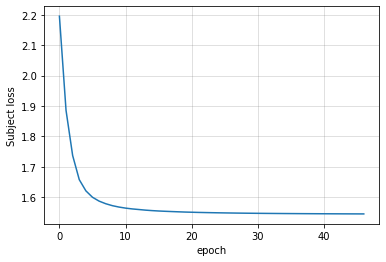

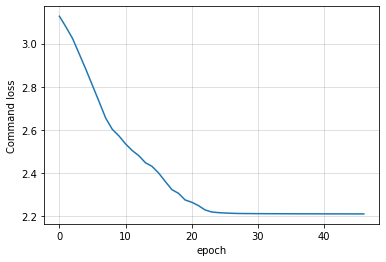

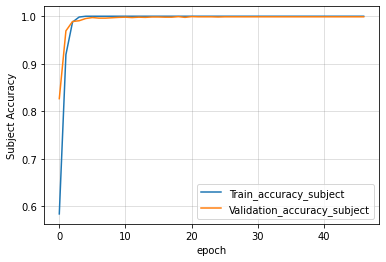

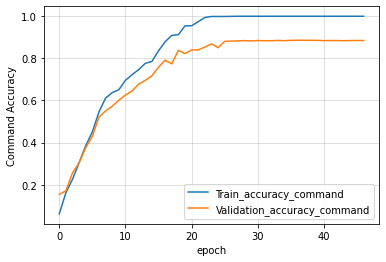

weight_a : 1.750000
1 run: 
-------------------------------
Epoch 1 :
loss: 6.647101402282715 , subject train accuracy: 0.6251521919454847 , command train accuracy: 0.08030641238604273 , val subject accuracy: 0.7968379446640316 , val command accuracy: 0.1422924901185771
Epoch 2 :
loss: 6.133411407470703 , subject train accuracy: 0.8878348214285714 , command train accuracy: 0.16507711048637116 , val subject accuracy: 0.908695652173913 , val command accuracy: 0.1691699604743083
Epoch 3 :
loss: 5.994251251220703 , subject train accuracy: 0.9252739452889988 , command train accuracy: 0.2347301138298852 , val subject accuracy: 0.9450592885375494 , val command accuracy: 0.2450592885375494
Epoch 4 :
loss: 6.009444236755371 , subject train accuracy: 0.9710328738604274 , command train accuracy: 0.2955560066870281 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.2901185770750988
Epoch 5 :
loss: 5.692511558532715 , subject train accuracy: 1.0 , command train accuracy: 0.3530336

loss: 4.912084579467773 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 44 :
loss: 4.911818504333496 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8818181818181818
Epoch 45 :
loss: 4.912015438079834 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 46 :
loss: 4.91120719909668 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 47 :
loss: 4.911169528961182 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 48 :
loss: 4.911224365234375 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

loss: 4.915407180786133 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8699604743083004
Epoch 33 :
loss: 4.914559841156006 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8691699604743083
Epoch 34 :
loss: 4.914008140563965 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8683794466403162
Epoch 35 :
loss: 4.913906097412109 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8695652173913043
Epoch 36 :
loss: 4.913645267486572 , subject train accuracy: 1.0 , command train accuracy: 0.9988839285714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8695652173913043
Epoch 37 :
loss: 4.913489341735

loss: 5.108392715454102 , subject train accuracy: 1.0 , command train accuracy: 0.8672889620065689 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7478260869565218
Epoch 21 :
loss: 5.011364459991455 , subject train accuracy: 1.0 , command train accuracy: 0.8705864452889988 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7679841897233202
Epoch 22 :
loss: 5.069686412811279 , subject train accuracy: 1.0 , command train accuracy: 0.9280641238604274 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.8146245059288537
Epoch 23 :
loss: 4.9693450927734375 , subject train accuracy: 1.0 , command train accuracy: 0.9888392857142857 , val subject accuracy: 0.9964426877470356 , val command accuracy: 0.8241106719367589
Epoch 24 :
loss: 4.924818992614746 , subject train accuracy: 1.0 , command train accuracy: 0.9994419642857143 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8430830039525692
Epoch 25 :
loss: 4.92179298400

loss: 5.025979995727539 , subject train accuracy: 1.0 , command train accuracy: 0.8248275167175702 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7296442687747036
Epoch 16 :
loss: 5.022599220275879 , subject train accuracy: 1.0 , command train accuracy: 0.8259435881461415 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7458498023715415
Epoch 17 :
loss: 5.149312496185303 , subject train accuracy: 1.0 , command train accuracy: 0.8460836048637118 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.7782608695652173
Epoch 18 :
loss: 5.036897659301758 , subject train accuracy: 1.0 , command train accuracy: 0.9012784095747131 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.7822134387351779
Epoch 19 :
loss: 4.955200672149658 , subject train accuracy: 1.0 , command train accuracy: 0.9129464285714286 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8094861660079051
Epoch 20 :
loss: 4.937775135040

loss: 5.328205108642578 , subject train accuracy: 1.0 , command train accuracy: 0.5521002433129719 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.475098814229249
Epoch 12 :
loss: 5.278536319732666 , subject train accuracy: 1.0 , command train accuracy: 0.5822341718844005 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.5011857707509881
Epoch 13 :
loss: 5.406203269958496 , subject train accuracy: 1.0 , command train accuracy: 0.601816152887685 , val subject accuracy: 0.9968379446640316 , val command accuracy: 0.508695652173913
Epoch 14 :
loss: 5.207845687866211 , subject train accuracy: 1.0 , command train accuracy: 0.6067370133740562 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.5221343873517786
Epoch 15 :
loss: 5.383443832397461 , subject train accuracy: 1.0 , command train accuracy: 0.6230215100305421 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.5458498023715415
Epoch 16 :
loss: 5.095921516418457

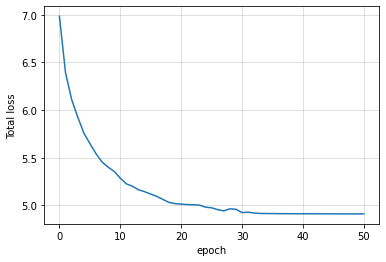

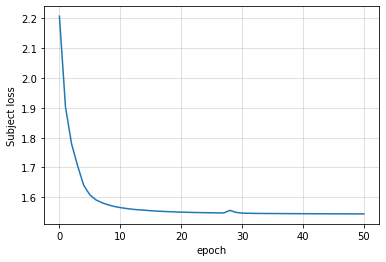

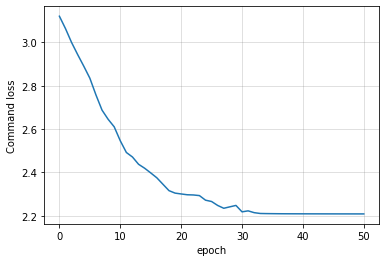

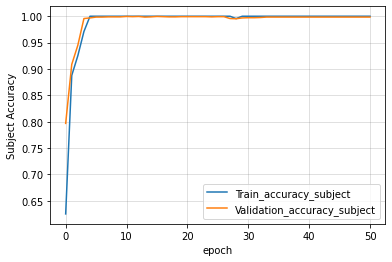

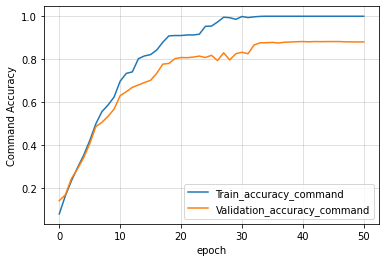

weight_a : 2.000000
1 run: 
-------------------------------
Epoch 1 :
loss: 7.216104507446289 , subject train accuracy: 0.5190746762922832 , command train accuracy: 0.06523944810032845 , val subject accuracy: 0.8442687747035573 , val command accuracy: 0.09802371541501977
Epoch 2 :
loss: 6.838645935058594 , subject train accuracy: 0.8627739452889988 , command train accuracy: 0.10993303571428571 , val subject accuracy: 0.8865612648221344 , val command accuracy: 0.13043478260869565
Epoch 3 :
loss: 6.474445819854736 , subject train accuracy: 0.9029525167175702 , command train accuracy: 0.16943993525845663 , val subject accuracy: 0.9055335968379447 , val command accuracy: 0.1893280632411067
Epoch 4 :
loss: 6.3340582847595215 , subject train accuracy: 0.9135551952889988 , command train accuracy: 0.24081777621592795 , val subject accuracy: 0.9343873517786562 , val command accuracy: 0.25138339920948616
Epoch 5 :
loss: 6.25322151184082 , subject train accuracy: 0.9810267857142857 , command trai

loss: 5.299049377441406 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8782608695652174
Epoch 44 :
loss: 5.298796653747559 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8786561264822135
Epoch 45 :
loss: 5.298398971557617 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8790513833992095
Epoch 46 :
loss: 5.298549652099609 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8794466403162056
Epoch 47 :
loss: 5.298133850097656 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8794466403162056
Epoch 48 :
loss: 5.297928810119629 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subje

loss: 6.221094608306885 , subject train accuracy: 0.9821428571428571 , command train accuracy: 0.30174513001527103 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.30039525691699603
Epoch 5 :
loss: 6.05277156829834 , subject train accuracy: 0.9994419642857143 , command train accuracy: 0.4020900976444994 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.3786561264822134
Epoch 6 :
loss: 5.932478904724121 , subject train accuracy: 0.9994419642857143 , command train accuracy: 0.5013697243162564 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.47865612648221345
Epoch 7 :
loss: 5.843271732330322 , subject train accuracy: 1.0 , command train accuracy: 0.5895393671733993 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.5339920948616601
Epoch 8 :
loss: 5.865475654602051 , subject train accuracy: 1.0 , command train accuracy: 0.629159902887685 , val subject accuracy: 0.9976284584980237 , val command accuracy: 0.566798

loss: 5.297336578369141 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8857707509881423
Epoch 49 :
loss: 5.297114372253418 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8861660079051383
Epoch 50 :
loss: 5.29679012298584 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8857707509881423
Epoch 51 :
loss: 5.296774864196777 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8865612648221344
Epoch 52 :
loss: 5.296667098999023 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8869565217391304
Epoch 53 :
loss: 5.296540260314941 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

loss: 5.311677932739258 , subject train accuracy: 1.0 , command train accuracy: 0.9542410714285714 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8075098814229249
Epoch 25 :
loss: 5.396271705627441 , subject train accuracy: 1.0 , command train accuracy: 0.9548498381461415 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8063241106719368
Epoch 26 :
loss: 5.306886672973633 , subject train accuracy: 1.0 , command train accuracy: 0.9559151785714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8308300395256917
Epoch 27 :
loss: 5.3072509765625 , subject train accuracy: 1.0 , command train accuracy: 0.9559151785714286 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8296442687747035
Epoch 28 :
loss: 5.33299446105957 , subject train accuracy: 1.0 , command train accuracy: 0.9921875 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.7956521739130434
Epoch 29 :
loss: 5.3091888427734375 , subje

loss: 5.3226094245910645 , subject train accuracy: 1.0 , command train accuracy: 0.9447544642857143 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8011857707509882
Epoch 21 :
loss: 5.404160976409912 , subject train accuracy: 1.0 , command train accuracy: 0.9542918024318559 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8225296442687747
Epoch 22 :
loss: 5.398518085479736 , subject train accuracy: 1.0 , command train accuracy: 0.9548498381461415 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8426877470355731
Epoch 23 :
loss: 5.310543060302734 , subject train accuracy: 1.0 , command train accuracy: 0.9564732142857143 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.8446640316205534
Epoch 24 :
loss: 5.392297744750977 , subject train accuracy: 1.0 , command train accuracy: 0.9554078738604274 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.8470355731225296
Epoch 25 :
loss: 5.3611955642700

loss: 5.295538902282715 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8865612648221344
Epoch 66 :
loss: 5.295507431030273 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.8869565217391304
Run:  4 , and its best  1.8873517786561265

Run  4 Subject Accuracy 0.999604743083004 command Accuracy is : 0.88300395256917 Sub_1: 0.8869565217391304 Sub_2: 0.9043478260869565 Sub_3: 0.8608695652173913 Sub_4: 0.8826086956521739 Sub_5: 0.9043478260869565 Sub_6: 0.9391304347826087 Sub_7: 0.9521739130434783 Sub_8: 0.9347826086956522 Sub_9: 0.9130434782608695 Sub_10: 0.7956521739130434 Sub_11: 0.7391304347826086
5 run: 
-------------------------------
Epoch 1 :
loss: 6.918559551239014 , subject train accuracy: 0.6796875 , command train accuracy: 0.09258319810032845 , val subject accuracy: 0.8707509881422925 , val command accuracy: 0.15652173913

loss: 5.299500465393066 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8711462450592885
Epoch 40 :
loss: 5.298697471618652 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.8707509881422925
Epoch 41 :
loss: 5.298281192779541 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8719367588932806
Epoch 42 :
loss: 5.298515319824219 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8727272727272727
Epoch 43 :
loss: 5.2980804443359375 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8735177865612648
Epoch 44 :
loss: 5.297980308532715 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subj

loss: 5.294546127319336 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8810276679841897
Epoch 86 :
loss: 5.294526100158691 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8814229249011858
Epoch 87 :
loss: 5.29446268081665 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 88 :
loss: 5.294460773468018 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8818181818181818
Epoch 89 :
loss: 5.294469833374023 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.8822134387351779
Epoch 90 :
loss: 5.294428825378418 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subjec

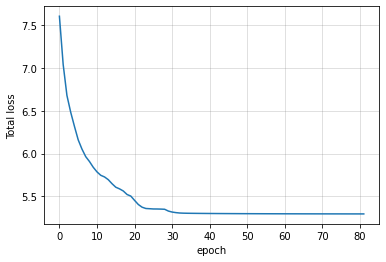

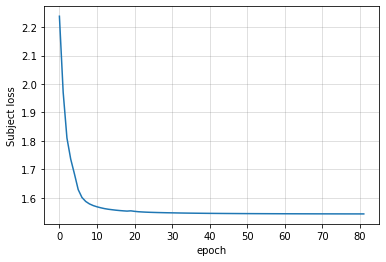

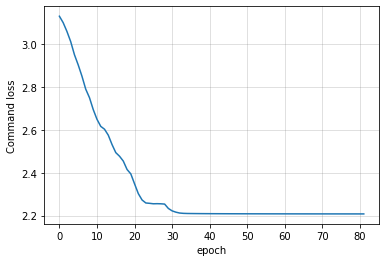

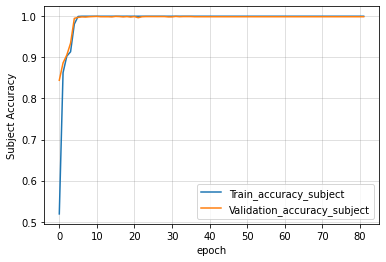

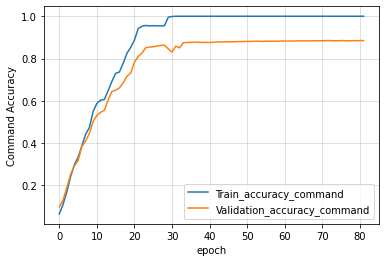

In [18]:
unfreeze_bool = True
Perfomance = pd.DataFrame()
# Perfomance = pd.read_csv('Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_7Image_weight_a_0419.csv')

for weight_a in [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2.0]: #[0.25,0.5,0.75,1,1.25,1.5,1.75]
    MODEL_LIST = []
    LOSS_LIST = []
    best_in_total = 0
    print('weight_a : %f'%(weight_a))

    for run in range(0,5):
        print(f"{run + 1} run: \n-------------------------------") 
        resnet = models.resnet18(pretrained=True)
        PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
        model = CombinedModel(PRETRAIN_MODEL,keyword_net())

        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        model.to(device)
        Train_accuracy_sub = []
        Train_accuracy_comd = []
        Val_accuracy_sub = [] 
        Val_accuracy_comd = [] 
        losses_sub = []
        losses_com = [] 
        total_losses = []
        best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
        best_in_run = 0
        patience = 0
        start = timeit.default_timer()
        for epoch in range(100):
            print(f"Epoch {epoch + 1} :")
            for param in model.pretrain_model.parameters():
                param.requires_grad = unfreeze_bool
            for param in model.keyword_net.parameters():
                param.requires_grad = True
            t_acc_comd = []   
            t_acc_sub = []   
    #         for name, param in model.named_parameters():
    #             if param.requires_grad:
    #                 print(f"{name} is trainable")
    #             else:
    #                 print(f"{name} is frozen")
            losses_sub_batch=[]
            losses_com_batch=[]
            total_loss_batch=[]
            for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
                x_batch = x_batch.to(device)
                y_batch_sub = y_batch_sub.to(device)
                y_batch_comd = y_batch_comd.to(device)
                pred_y = model(x_batch)
                loss_sub = loss_function(pred_y[0], y_batch_sub)
                loss_mov = loss_function(pred_y[1], y_batch_comd)
                loss = weight_a*loss_sub + loss_mov
                model.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss_batch.append(loss.item())
                losses_sub_batch.append(loss_sub.item())
                losses_com_batch.append(loss_mov.item())
                t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
                t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
            losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
            losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
            total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
            Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
            Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
            for param in model.parameters():
                param.requires_grad = False
            model.eval()
            v_sub_pred = []
            v_comd_pred = [] 
            v_sub_real = []
            v_comd_real = []
            for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
                x_batch = x_batch.to(device)
                y_batch_sub = y_batch_sub.to(device)
                y_batch_comd = y_batch_comd.to(device)
                pred_y = model(x_batch)
                v_sub_real.append( torch.argmax (y_batch_sub, 1))
                v_comd_real.append( torch.argmax (y_batch_comd, 1))
                v_sub_pred.append(torch.argmax(pred_y[0], 1) )
                v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

            v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
            v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
            v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
            v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
            Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
            Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
            print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
                  ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
                  ", val command accuracy:",Val_accuracy_comd[-1])
            if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
                best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
                patience = 0
                best_state_dict_in_run = copy.deepcopy(model.state_dict())
                if best_in_run > best_in_total: 
                    best_in_total = best_in_run
                    best_state_dict_in_total = copy.deepcopy(model.state_dict())
            else:
                patience = patience + 1
            if patience>=10:
                print("Run: ", run+1, ", and its best ",best_in_run)
                break    
        stop = timeit.default_timer()
        run_time = stop - start
        del model
        torch.cuda.empty_cache()
        # testing phase
        best_model.load_state_dict(best_state_dict_in_run)
        MODEL_LIST.append( best_state_dict_in_run)
        LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                          'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                         'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
        for param in best_model.parameters():
            param.requires_grad = False
        pred_y_sub = []
        pred_y_comd = []
        best_model.to(device)
        best_model.eval() 
        for i in range(Test_Inputs.shape[1]):
            pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
            pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
        sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
        comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

        acc_on_subjects=[]
        for s in range(1,12):
            tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
            x_test = tensordata.to(device)
            y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
            pred_y_comd = []
            for i in range(len(x_test)):
                pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
            comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
            acc_on_subjects.append(comd_acc_s.item()) 

        Perfomance = Perfomance.append({'weight_a':weight_a,'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                       'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                        'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                        'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                        'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
        print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                        'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                        'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                        'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

        # # Load the state dictionary into the new model
    #     del best_model
        torch.cuda.empty_cache()

    best_index = (Perfomance.loc[Perfomance['weight_a']==weight_a,'Command Accuracy'] + Perfomance.loc[Perfomance['weight_a']==weight_a,'Subject Accuracy']).idxmax()
    best_index = Perfomance.loc[best_index,'Run'].item() - 1
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_model.load_state_dict(MODEL_LIST[int(best_index)])
    best_loss_record = LOSS_LIST[int(best_index)]

    Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_7Image_weight_a_0421.csv",index=False)

    plt.plot(best_loss_record['total'])
    plt.ylabel('Total loss')
    plt.xlabel('epoch')
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['sub'])
    plt.ylabel('Subject loss')
    plt.xlabel('epoch')
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['comd'])
    plt.ylabel('Command loss')
    plt.grid(color='gray', alpha=0.3)
    plt.xlabel('epoch')
    plt.show()


    plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
    plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
    plt.ylabel('Subject Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
    plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
    plt.ylabel('Command Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(color='gray', alpha=0.3)
    plt.show()


In [19]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time,weight_a
0,0.823715,1.0,0.873913,0.673913,0.678261,0.843478,0.852174,0.869565,0.856522,0.865217,0.886957,0.860870,0.800000,0.078261,1077.047877,0.00
1,0.821739,2.0,0.860870,0.730435,0.656522,0.817391,0.817391,0.869565,0.852174,0.886957,0.869565,0.860870,0.817391,0.093281,880.727424,0.00
2,0.822530,3.0,0.860870,0.739130,0.669565,0.852174,0.817391,0.860870,0.860870,0.843478,0.860870,0.882609,0.800000,0.090909,833.788101,0.00
3,0.827273,4.0,0.847826,0.691304,0.656522,0.808696,0.891304,0.882609,0.847826,0.891304,0.860870,0.856522,0.865217,0.084585,598.766717,0.00
4,0.821739,5.0,0.856522,0.773913,0.647826,0.834783,0.843478,0.895652,0.843478,0.860870,0.856522,0.839130,0.786957,0.070356,1706.029393,0.00
5,0.878656,1.0,0.900000,0.800000,0.726087,0.886957,0.878261,0.886957,0.900000,0.921739,0.943478,0.921739,0.900000,0.999209,1849.799099,0.25
6,0.883004,2.0,0.900000,0.817391,0.756522,0.908696,0.895652,0.900000,0.886957,0.913043,0.913043,0.921739,0.900000,0.999209,1007.274614,0.25
7,0.861660,3.0,0.900000,0.778261,0.691304,0.904348,0.834783,0.908696,0.873913,0.886957,0.908696,0.904348,0.886957,0.998814,1086.921555,0.25
8,0.883004,4.0,0.917391,0.830435,0.682609,0.886957,0.895652,0.913043,0.882609,0.926087,0.934783,0.917391,0.926087,0.998814,1138.384492,0.25
9,0.870356,5.0,0.878261,0.778261,0.730435,0.856522,0.873913,0.930435,0.891304,0.943478,0.930435,0.869565,0.891304,0.999209,894.128180,0.25
